In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Adjust the path for c2qa and bosonic-qiskit modules
module_path = os.path.abspath(os.path.join('..', '..', '..'))  # Moves three directories up
if module_path not in sys.path:
    sys.path.append(module_path)

# Add the `playground` directory to the Python path
playground_path = Path.cwd().parent.parent  # Move two levels up to `playground`
if str(playground_path) not in sys.path:
    sys.path.append(str(playground_path))


# Qiskit and related imports
# Qiskit and related imports
import qiskit
from qiskit.quantum_info import state_fidelity, Statevector, SparsePauliOp, Operator
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter

# Project-specific imports
import c2qa
import c2qa.util as util
from bosonic_operator_costs.all_qubit_utils import (
    create_annihilation_operator,
    create_creation_operator
)



### Pure trotterization method

In [2]:
def displacement_hamiltonian(n_max, alpha=1):
    """
    Creates the matrix representation of the operator i*alpha(b^dagger - b).

    Parameters:
        n_max (int): The Fock cutoff.
        alpha (complex, optional): The amount of displacement. Defaults to 1.

    Returns:
        np.ndarray: The matrix representation of i*alpha(b^dagger - b).
    """
    b = create_annihilation_operator(n_max)
    b_dag = create_creation_operator(n_max)

    hamiltonian = 1j* (alpha * b_dag - alpha.conjugate() * b)
    return hamiltonian


def define_initial_state(num_modes, n_max):
    """
    Define the initial state vector for the system.

    Parameters:
        n_qubits (int): The number of qubits in the system.

    Returns:
        Statevector: The initial quantum state.
    """
    n_qubits = num_modes * int(np.ceil(np.log2(n_max + 1)))
    initial_state_vector = np.zeros(2**n_qubits, dtype=complex)
    initial_state_vector[0] = 1.0

    return Statevector(initial_state_vector)

We're currently only doing a single trotter step, and there isn't really anyway to change that, as there's no option to repeat the trotter steps

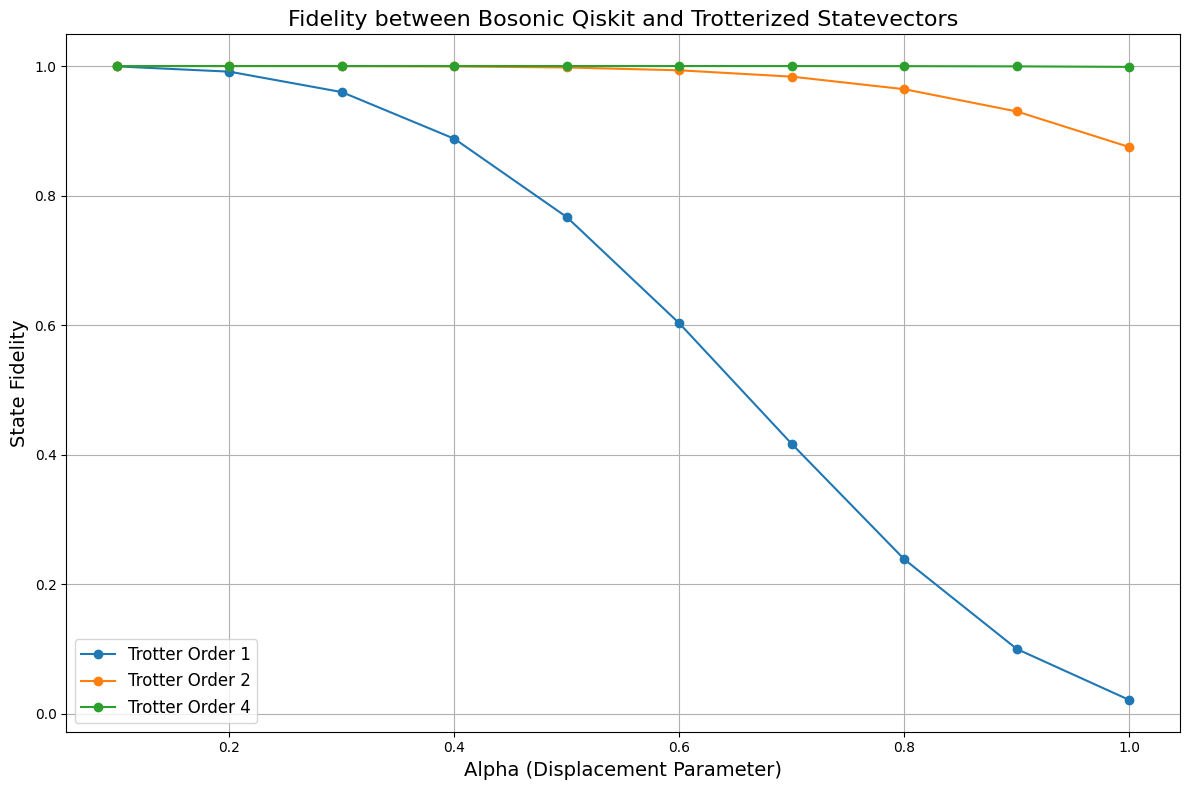

In [3]:
# =============================================================================
# Parameters and Hamiltonian Setup
# =============================================================================
num_qubits_per_mode = 3
n_max = 2**num_qubits_per_mode - 1
num_modes = 1

# Time evolution parameters
evolution_time = 1.0       # Total evolution time
num_timesteps = 1       # Number of Trotter steps
dt = evolution_time / num_timesteps  # Time step size
# Range of alpha values for displacement
alpha_values = np.linspace(0.1, 1.0, 10)  

# Trotter orders to evaluate
trotter_orders = [1, 2, 4]

# Initialize dictionary to store fidelity results for each Trotter order
fidelity_results = {order: [] for order in trotter_orders}

# =============================================================================
# Function for Trotter Evolution with Variable Order
# =============================================================================
def get_trotter_circuit(H, dt, initial_state, order=1):
    """
    Applies Trotter evolution to the initial_state using the specified order
    and returns the resulting statevector.

    Parameters:
    - H (SparsePauliOp): Hamiltonian operator.
    - dt (float): Time step size.
    - initial_state (Statevector): Initial quantum state.
    - order (int): Order of the Trotter formula (1, 2, 4, 6).

    Returns:
    - Statevector: Evolved statevector after applying Trotter evolution.
    """
    # Select synthesis method based on desired order
    if order == 1:
        synthesis_method = LieTrotter()
    elif order == 2:
        synthesis_method = SuzukiTrotter()  # Defaults to second order
    elif order == 4:
        synthesis_method = SuzukiTrotter(order=4)
    elif order == 6:
        synthesis_method = SuzukiTrotter(order=6)
    else:
        raise ValueError(f"Unsupported Trotter order: {order}. Supported orders: 1, 2, 4, 6.")
    
    trotter_gate = PauliEvolutionGate(H, dt, synthesis=synthesis_method)
    circuit = QuantumCircuit(H.num_qubits)
    
    # Initialize the circuit with the initial_state
    circuit.initialize(initial_state.data, range(H.num_qubits))
    
    # Append the Trotter evolution gate
    circuit.append(trotter_gate, range(H.num_qubits))
    
    return circuit

# =============================================================================
# Loop Over Alpha Values and Compute Fidelities
# =============================================================================
for alpha in alpha_values:
    
    # Create initial state and displacement Hamiltonian
    initial_state = define_initial_state(num_modes, n_max)
    hamiltonian_matrix = displacement_hamiltonian(n_max, alpha)
    H = SparsePauliOp.from_operator(Operator(hamiltonian_matrix))
    
    # =============================================================================
    # Bosonic Qiskit Displacement Simulation
    # =============================================================================
    # Setup qumode registers for Bosonic Qiskit
    qmr = c2qa.QumodeRegister(1, num_qubits_per_qumode=num_qubits_per_mode)
    qumode = qmr[0]  # Convenient labeling
    
    # Initialize circuit (starts in |0⟩ by default)
    bosonic_circuit = c2qa.CVCircuit(qmr)
    
    # Apply displacement operation
    bosonic_circuit.cv_d(alpha, qumode)
    
    # Simulate bosonic circuit and obtain statevector
    bosonic_statevector, _, _ = c2qa.util.simulate(bosonic_circuit)
    
    # =============================================================================
    # Trotter Evolution and Fidelity Calculation for Each Order
    # =============================================================================
    for order in trotter_orders:

        # Compute Trotter circuit
        circuit = get_trotter_circuit(H, dt, initial_state, order=order)
        # Compute Trotterized statevector using the selected order
        trotter_statevector = Statevector.from_instruction(circuit)
        
        # Compute fidelity between bosonic and Trotterized statevectors
        fidelity = state_fidelity(bosonic_statevector, trotter_statevector)
        
        # Store fidelity
        fidelity_results[order].append(fidelity)

# =============================================================================
# Plot Fidelity vs Alpha for Each Trotter Order
# =============================================================================
plt.figure(figsize=(12, 8))
for order in trotter_orders:
    plt.plot(alpha_values, fidelity_results[order], 
             marker='o', linestyle='-', label=f'Trotter Order {order}')
plt.xlabel('Alpha (Displacement Parameter)', fontsize=14)
plt.ylabel('State Fidelity', fontsize=14)
plt.title('Fidelity between Bosonic Qiskit and Trotterized Statevectors', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


From the above, we can see that the fourth order trotterization, as expected, gives the best results. However, for each method, we can still calculate the number of entangling + rotation gates, and depth required.

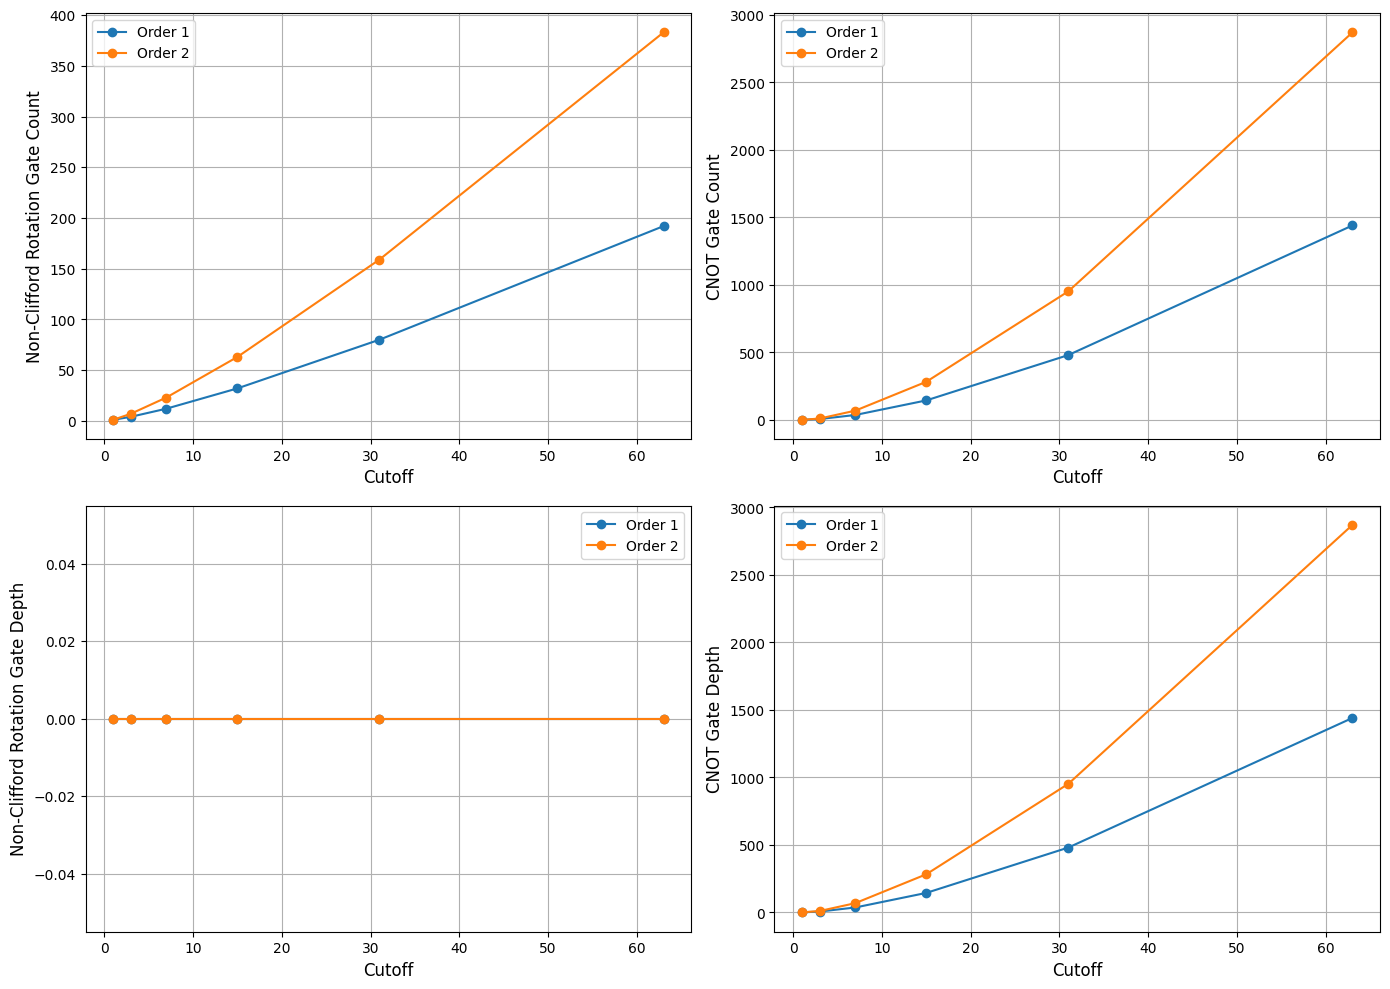

In [4]:
# =============================================================================
# Parameters for Gate Count Analysis
# =============================================================================
alpha_fixed = 0.5
evolution_time = 1
num_timesteps = 1
dt = evolution_time / num_timesteps #just a single trotter step

# Trotter orders to consider
trotter_orders = [1, 2]

# Range of num_qubits_per_mode values to simulate different cutoffs
qubit_counts = range(1, 7)  
cutoff_values = [2**q - 1 for q in qubit_counts]  # Corresponding cutoffs
num_modes = 1

# Dictionaries to store results: structure {order: [values for each cutoff]}
rotation_gate_counts = {order: [] for order in trotter_orders}
cnot_gate_counts = {order: [] for order in trotter_orders}
rotation_depths    = {order: [] for order in trotter_orders}
cnot_depths        = {order: [] for order in trotter_orders}

# =============================================================================
# Loop Over Cutoff Values and Compute Gate Counts and Depths for Each Order
# =============================================================================
for cutoff in cutoff_values:
    # Create initial state and Hamiltonian for current cutoff
    initial_state = define_initial_state(num_modes, cutoff)
    hamiltonian_matrix = displacement_hamiltonian(cutoff, alpha_fixed)
    H = SparsePauliOp.from_operator(Operator(hamiltonian_matrix))

    # Loop over each Trotter order
    for order in trotter_orders:
        # Get the decomposed Trotter circuit for the given order
        circuit = get_trotter_circuit(H, dt, initial_state, order=order).decompose(reps=1)

        # Count gates and compute depths using transpilation
        gate_counts = circuit.count_ops()
        r_gate_count = gate_counts.get('rz', 0)  
        r_gate_count += gate_counts.get('ry', 0)
        cnot_gate_count = gate_counts.get('cx', 0)  # CNOT gate count

        # Transpile circuit to measure depths for specific gates
        r_depth = circuit.depth(lambda instr: instr.operation.name == 'u3') ###needs to be fixed 
        cnot_depth = circuit.depth(lambda instr: instr.operation.name == 'cx')

        # Store the counts and depths
        rotation_gate_counts[order].append(r_gate_count)
        cnot_gate_counts[order].append(cnot_gate_count)
        rotation_depths[order].append(r_depth)
        cnot_depths[order].append(cnot_depth)

# =============================================================================
# Plotting in a 2x2 grid
# =============================================================================
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Rotation Gate Count vs Cutoff
for order in trotter_orders:
    axs[0, 0].plot(cutoff_values, rotation_gate_counts[order], marker='o', label=f'Order {order}')
axs[0, 0].set_xlabel('Cutoff', fontsize=12)
axs[0, 0].set_ylabel('Non-Clifford Rotation Gate Count', fontsize=12)
axs[0, 0].legend()
axs[0, 0].grid(True)

# CNOT Gate Count vs Cutoff
for order in trotter_orders:
    axs[0, 1].plot(cutoff_values, cnot_gate_counts[order], marker='o', label=f'Order {order}')
axs[0, 1].set_xlabel('Cutoff', fontsize=12)
axs[0, 1].set_ylabel('CNOT Gate Count', fontsize=12)
axs[0, 1].legend()
axs[0, 1].grid(True)

# Rotation Gate Depth vs Cutoff
for order in trotter_orders:
    axs[1, 0].plot(cutoff_values, rotation_depths[order], marker='o', label=f'Order {order}')
axs[1, 0].set_xlabel('Cutoff', fontsize=12)
axs[1, 0].set_ylabel('Non-Clifford Rotation Gate Depth', fontsize=12)
axs[1, 0].legend()
axs[1, 0].grid(True)

# CNOT Gate Depth vs Cutoff
for order in trotter_orders:
    axs[1, 1].plot(cutoff_values, cnot_depths[order], marker='o', label=f'Order {order}')
axs[1, 1].set_xlabel('Cutoff', fontsize=12)
axs[1, 1].set_ylabel('CNOT Gate Depth', fontsize=12)
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


# Trotter Analysis

### CNOT staircase count
Below, we calculate, based on a first order Trotterization, the number of CNOT gates and non-clifford rotations for a single trotter step in terms of the cutoff, using the fact that exponentiating a Pauli string of weight $p$ takes $2(p-1)$ CNOT gates and a single non-clifford rotation. There for if our Hamiltonian is $\sum_{j=1}^P p_j$ (written as a sum of $P$ Pauli strings), the CNOT gate count is $\sum_{j=1}^P 2(r_j -1)$ and $P$ non-clifford rotations. Note $I$ gates do not contribute to teh weight of $p$. 

As a check, we'll plot these counts alongside our actual Trotterized qiskit circuit.

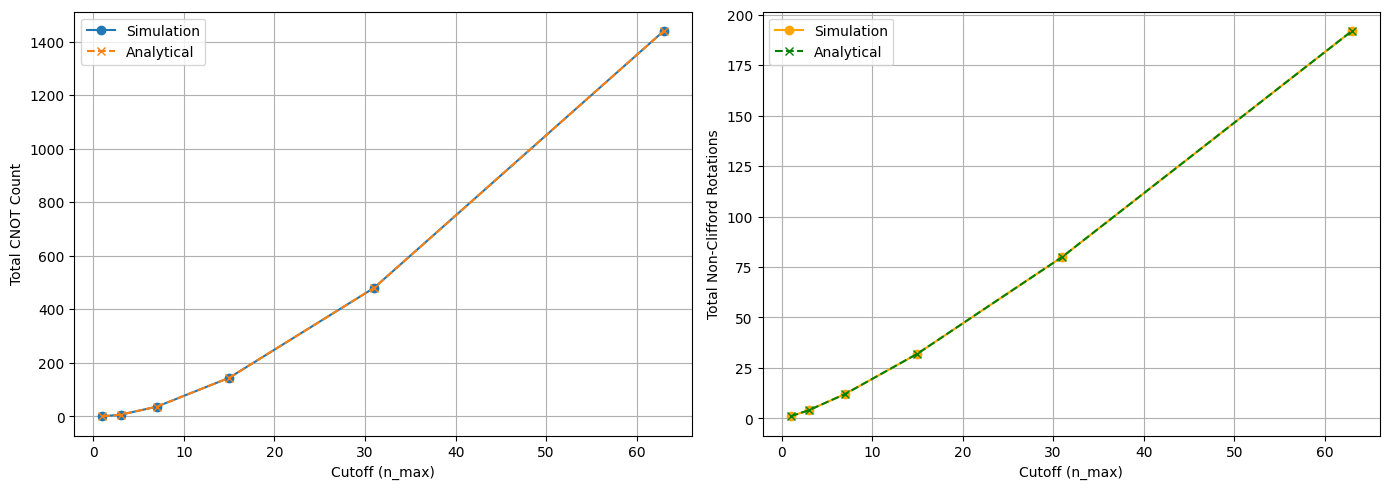

In [5]:
# =============================================================================
# Analytical Calculation
# =============================================================================

analytical_cnot_counts = []
analytical_nonclifford_counts = []

for cutoff in cutoff_values:
    # Generate the Hamiltonian matrix for the current cutoff
    hamiltonian_matrix = displacement_hamiltonian(cutoff, alpha_fixed)
    
    # Convert matrix to a SparsePauliOp
    H = SparsePauliOp.from_operator(Operator(hamiltonian_matrix))
    
    # Extract terms as a list of tuples: (pauli_string, coefficient)
    terms = H.to_list()
    
    # Initialize total CNOT count for this cutoff
    total_cnot_count = 0
    
    # For each term, calculate its effective length and add to total CNOT count
    for p_str, coeff in terms:
        # Calculate effective length ignoring 'I'
        effective_length = len(p_str.replace('I', ''))
        # Calculate CNOT count for the current term
        term_cnot = 2 * max(effective_length - 1, 0)
        # Add to the total CNOT count
        total_cnot_count += term_cnot
    
    analytical_cnot_counts.append(total_cnot_count)
    
    # For non-Clifford rotations: one rotation per term regardless of length
    nonclifford_count = len(terms)
    analytical_nonclifford_counts.append(nonclifford_count)

# =============================================================================
# Compare Simulation and Analytical Results
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Simulation results (order=1)
sim_cnot = cnot_gate_counts[1] 
axes[0].plot(cutoff_values, sim_cnot, marker='o', linestyle='-', label='Simulation')
# Analytical results
axes[0].plot(cutoff_values, analytical_cnot_counts, marker='x', linestyle='--', label='Analytical')
axes[0].set_xlabel('Cutoff (n_max)')
axes[0].set_ylabel('Total CNOT Count')
axes[0].legend()
axes[0].grid(True)

# Simulation results (order=1)
sim_rotations = rotation_gate_counts[1]
axes[1].plot(cutoff_values, sim_rotations, marker='o', linestyle='-', label='Simulation', color='orange')
# Analytical results
axes[1].plot(cutoff_values, analytical_nonclifford_counts, marker='x', linestyle='--', label='Analytical', color='green')
axes[1].set_xlabel('Cutoff (n_max)')
axes[1].set_ylabel('Total Non-Clifford Rotations')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Error Analysis
The leading-order error of this approximation can be bounded by the sum of pairwise commutators:
$$
\Big\|e^{-iHt} - \prod_i e^{-iH_i t}\Big\|
\leq \frac{t^2}{2} \sum_{i < j} \big\|\,[H_i,\,H_j]\,\big\| + \mathcal{O}(t^3).
$$

In [6]:
# Function to compute the spectral norm of the commutator between two groups
def commutator_spectral_norm(group_A, group_B):
    # Convert group operators to dense matrix form
    A_matrix = group_A.to_matrix()
    B_matrix = group_B.to_matrix()
    
    # Compute the commutator: [A, B] = AB - BA
    commutator = A_matrix @ B_matrix - B_matrix @ A_matrix
    
    # Return the spectral norm (largest singular value) of the commutator
    return np.linalg.norm(commutator, 2)

def compute_error_sum(hamiltonian_matrix):
    """
    Given a list of commuting groups (H_groups), compute the sum of spectral
    norms of commutators over all distinct pairs of groups.
    """
    # Create SparsePauliOp from the operator and group commuting terms
    H = SparsePauliOp.from_operator(Operator(hamiltonian_matrix))
    H_groups = H.group_commuting()

    error_sum = 0.0
    num_groups = len(H_groups)
    for i in range(num_groups):
        for j in range(i + 1, num_groups):
            error_sum += commutator_spectral_norm(H_groups[i], H_groups[j])
    return error_sum


# Define lists of n_max and alpha values to loop over
nmax_values = [1, 3, 7]          
alpha_values = [0.1, 0.5, 1.0] 

# Dictionary to hold error estimates keyed by alpha and n_max
error_estimates = {}

for alpha in alpha_values:
    # Initialize dictionary for current alpha's results
    error_estimates[alpha] = {}
    for n_max in nmax_values:
        # Generate the Hamiltonian matrix for current n_max and alpha
        hamiltonian_matrix = displacement_hamiltonian(n_max, alpha)

        # Compute the error sum for these groups using our function
        error_sum = compute_error_sum(hamiltonian_matrix)

        # Store the result
        error_estimates[alpha][n_max] = error_sum

for alpha in alpha_values:
    print(f"\nAlpha = {alpha}:")
    for n_max in nmax_values:
        error = error_estimates[alpha][n_max]
        print(f"  n_max = {n_max}: Error estimate ~ {error} * t^2")


Alpha = 0.1:
  n_max = 1: Error estimate ~ 0.0 * t^2
  n_max = 3: Error estimate ~ 0.024494897427831785 * t^2
  n_max = 7: Error estimate ~ 0.14111786567417342 * t^2

Alpha = 0.5:
  n_max = 1: Error estimate ~ 0.0 * t^2
  n_max = 3: Error estimate ~ 0.6123724356957945 * t^2
  n_max = 7: Error estimate ~ 3.5279466418543355 * t^2

Alpha = 1.0:
  n_max = 1: Error estimate ~ 0.0 * t^2
  n_max = 3: Error estimate ~ 2.449489742783178 * t^2
  n_max = 7: Error estimate ~ 14.111786567417342 * t^2
